## Testing The Model
In this notebook we'll use our trained model we 've constructed on some images from the web.

In [190]:
import PIL.Image
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

In [191]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [192]:
# Function to configure inputs so that can be accepted by the model
def load_image(img_path):
    img = PIL.Image.open(img_path)
    img = img.convert('RGB')
    img = transform(img)
    return img

In [193]:
def visualize_image(image_tensor):
    image_numpy = image_tensor.numpy()
    image_numpy = image_numpy.transpose((1, 2, 0)) # Transpose the dimensions to (height, width, channels)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image_numpy = (image_numpy * std) + mean
    image_numpy = np.clip(image_numpy, 0, 1)  # Clip the values to be within [0, 1]
    plt.imshow(image_numpy)
    plt.axis('off')
    plt.show()

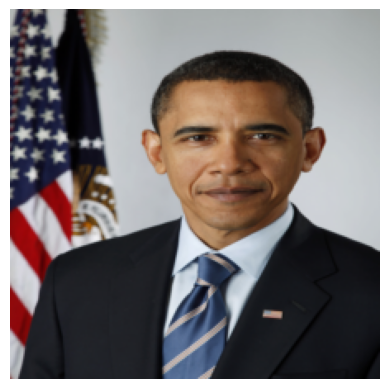

In [194]:
visualize_image(load_image("Official_portrait_of_Barack_Obama.jpg"))

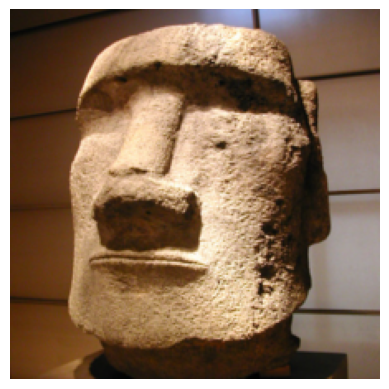

In [195]:
visualize_image(load_image("stone_face.jpg"))

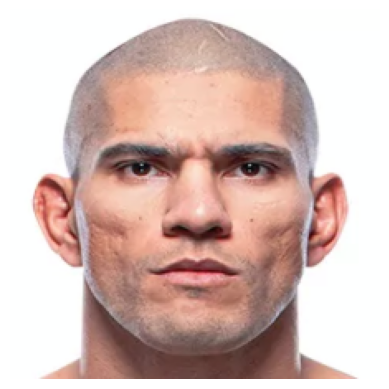

In [196]:
visualize_image(load_image("Alex_poatan_pereira.jpg"))

In [197]:
# Load the VGG16 model and freeze its layers
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

In [198]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.vgg = models.vgg16(pretrained=True).features
        self.fc_in_features = 2 * 512
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.vgg.apply(self.init_weights)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.vgg(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features
        output = torch.cat((output1, output2), 1)

        # reshape the concatenated output to match the linear layer's input size
        output = output.view(output.size(0), -1)

        # pass the reshaped tensor to the linear layers
        output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output = self.sigmoid(output)

        return output

#### Load the model

In [199]:
siamese_model = SiameseNetwork()
# Load the state dictionary
state_dict = torch.load("siamese_model.pth", map_location=torch.device('cpu'))
siamese_model.load_state_dict(state_dict)

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
siamese_model.to(device)

SiameseNetwork(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [200]:
# Load images
input1 = load_image("President_Barack_Obama.jpg")
input2 = load_image("stone_face.jpg")
input1 = input1.unsqueeze(0).to(device)
input2 = input2.unsqueeze(0).to(device)

In [201]:
# Get the similarity output
output = siamese_model(input1, input2)

In [202]:
output

tensor([[0.0546]], grad_fn=<SigmoidBackward0>)

In [203]:
input1 = load_image("stone_face.jpg")
input2 = load_image("Alex_poatan_pereira.jpg")

In [204]:
input1 = input1.unsqueeze(0).to(device)
input2 = input2.unsqueeze(0).to(device)
output = siamese_model(input1, input2)

In [205]:
output

tensor([[0.7931]], grad_fn=<SigmoidBackward0>)